Data berhasil dimuat. Berikut 5 baris pertama:
   Waktu Relatif (s)  Nilai Sensor
0              0.000          11.6
1              0.100          14.9
2              0.200          13.0
3              0.301          13.1
4              0.401          11.8


--- Hasil Simulasi DDSA (Threshold-based) ---
Jumlah titik data asli: 100
Jumlah titik data setelah sampling: 44
Threshold yang digunakan: 1.93
Data direduksi sebesar 56.00%
Mean Absolute Error (MAE): 1.0089



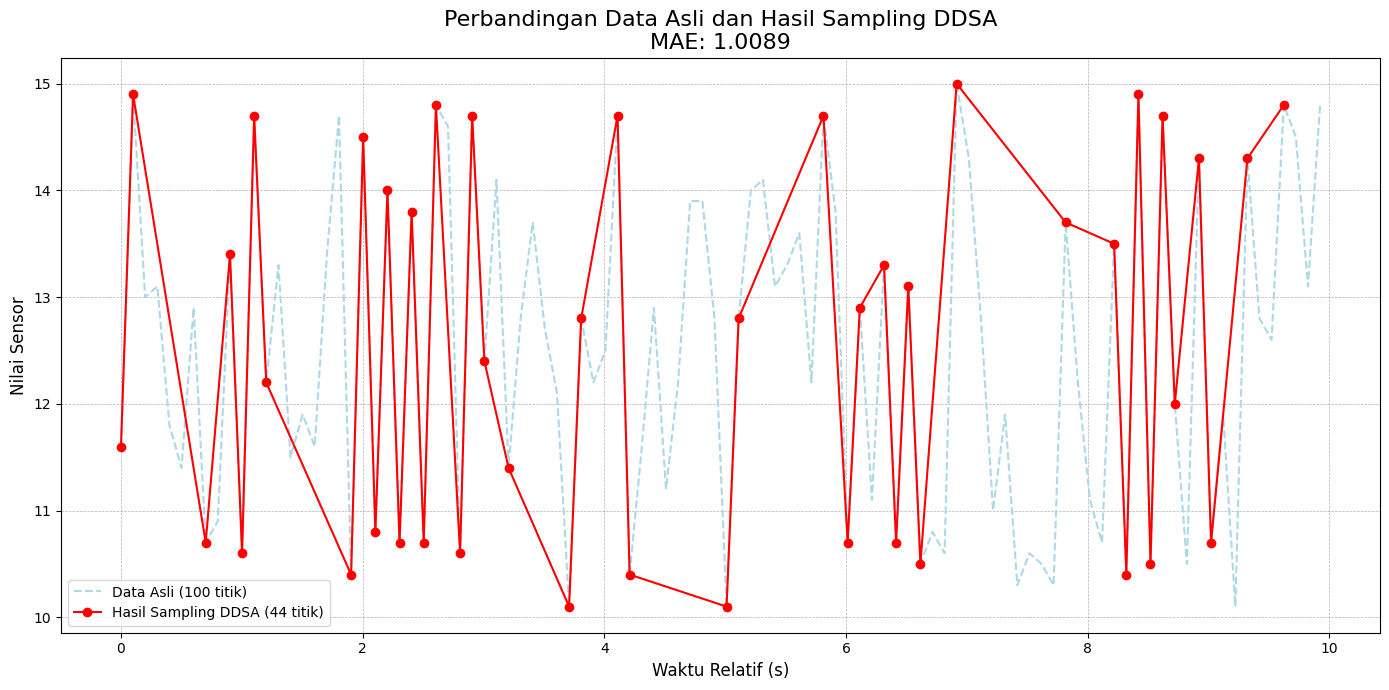

--- Hasil Simulasi DSRA (Slope-based) ---
Jumlah titik data asli: 100
Jumlah titik data setelah sampling: 18
Data direduksi sebesar 82.00%
Mean Absolute Error (MAE): 1.3647



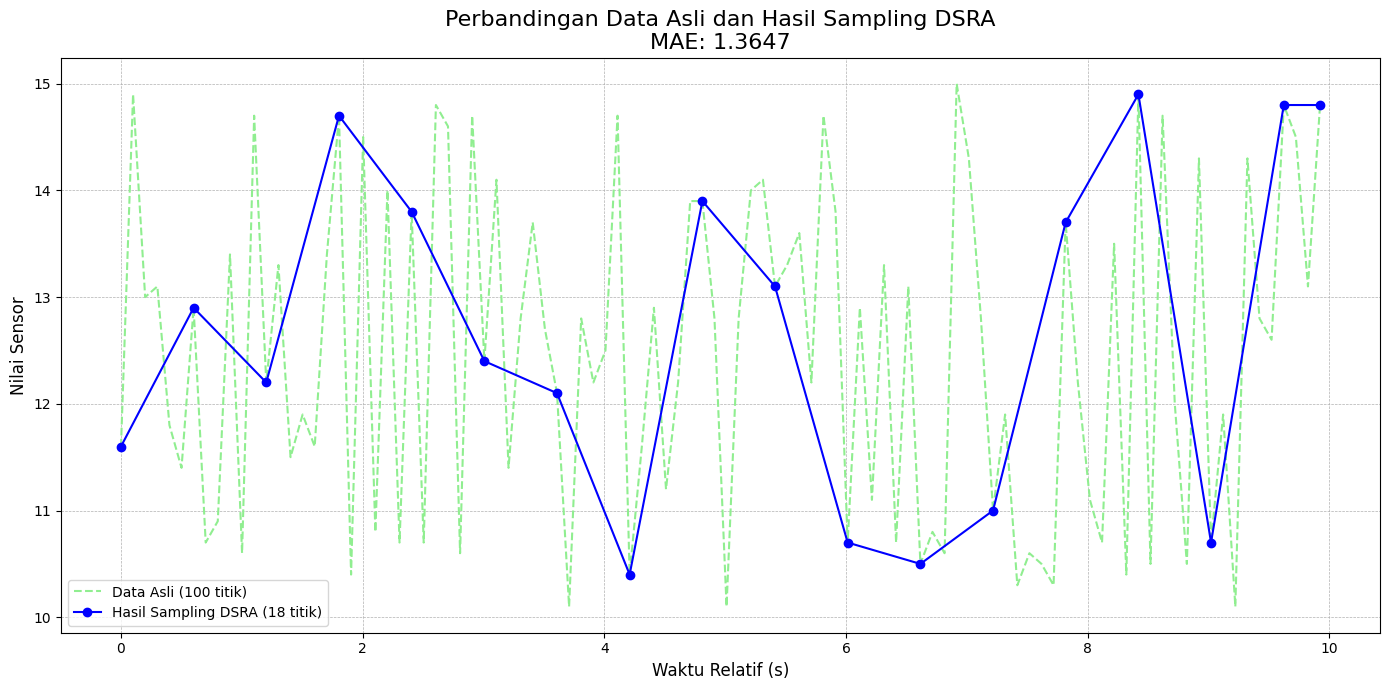

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Fungsi untuk Simulasi Data-Driven Adaptive Sampling (DDSA) ---
def data_driven_adaptive_sampling(data, threshold_method='mean'):
    """
    Melakukan sampling adaptif berdasarkan perubahan nilai data.
    Data akan diambil jika perubahannya melebihi ambang batas (threshold).
    """
    data_copy = data.copy()
    # Menghitung perubahan (selisih) nilai sensor antar titik data
    data_copy['Perubahan'] = data_copy['Nilai Sensor'].diff().abs()

    # Menentukan ambang batas (threshold)
    if threshold_method == 'mean':
        threshold = data_copy['Perubahan'].mean()
    elif threshold_method == 'median':
        threshold = data_copy['Perubahan'].median()
    else: # Default ke mean
        threshold = data_copy['Perubahan'].mean()

    # Selalu sertakan titik data pertama
    sampled_indices = [0]
    # Iterasi untuk mencari titik data yang melebihi threshold
    for i in range(1, len(data_copy)):
        if data_copy['Perubahan'].iloc[i] > threshold:
            sampled_indices.append(i)

    sampled_data = data_copy.iloc[sampled_indices]
    return sampled_data, threshold

# --- Fungsi untuk Simulasi Dynamic Slope Rate Adjustment (DSRA) ---
def dynamic_slope_rate_adjustment(data, E, S, epsilon, MIN_TBM, MAX_TBM, filter_window=3):
    """
    Mengimplementasikan algoritma DSRA berdasarkan pseudocode.
    Interval sampling (TBM) diatur secara dinamis berdasarkan kemiringan (slope) sinyal.
    """
    # Langkah Pemrosesan Sinyal: Terapkan filter sederhana (Simple Moving Average)
    data_filtered = data.copy()
    data_filtered['Nilai Sensor Filtered'] = data_filtered['Nilai Sensor'].rolling(window=filter_window, min_periods=1, center=True).mean()

    # Inisialisasi
    sampled_points = [data_filtered.iloc[0]]
    last_value_filtered = sampled_points[0]['Nilai Sensor Filtered']
    last_time = sampled_points[0]['Waktu Relatif (s)']
    current_index = 0

    while current_index < len(data_filtered) - 1:
        # Ambil nilai saat ini dari posisi terakhir yang di-sample
        current_value_filtered = data_filtered.iloc[current_index]['Nilai Sensor Filtered']
        current_time = data_filtered.iloc[current_index]['Waktu Relatif (s)']

        # Langkah Logika Inti DSRA
        time_delta = current_time - last_time
        value_delta = current_value_filtered - last_value_filtered

        if time_delta > 0:
            slope = abs(value_delta / time_delta)
        else:
            slope = 0

        # Hitung TBM (Time Between Measurements)
        TBM = E - (S * slope) + epsilon
        TBM = np.clip(TBM, MIN_TBM, MAX_TBM) # Pastikan TBM berada dalam batas aman

        # Langkah Penjadwalan: Tentukan waktu sample berikutnya
        next_sample_time = current_time + TBM

        # Cari indeks data asli yang paling dekat dengan waktu sample berikutnya
        # Ini adalah simulasi dari "SCHEDULE_NEXT_READ"
        future_times = data_filtered['Waktu Relatif (s)'][data_filtered['Waktu Relatif (s)'] > current_time]
        if future_times.empty:
            break
        
        next_index = (future_times - next_sample_time).abs().idxmin()

        # Tambahkan titik data yang ditemukan ke hasil sampling
        sampled_points.append(data_filtered.iloc[next_index])

        # Perbarui Status
        last_value_filtered = data_filtered.iloc[next_index]['Nilai Sensor Filtered']
        last_time = data_filtered.iloc[next_index]['Waktu Relatif (s)']
        current_index = next_index
        
    return pd.DataFrame(sampled_points).drop_duplicates()

# --- Fungsi untuk Menghitung Error Rekonstruksi ---
def calculate_reconstruction_error(original_data, sampled_data):
    """
    Menghitung Mean Absolute Error (MAE) antara sinyal asli dan
    sinyal yang direkonstruksi dari data hasil sampling menggunakan interpolasi linear.
    """
    # Waktu dan nilai dari data hasil sampling
    sample_times = sampled_data['Waktu Relatif (s)'].values
    sample_values = sampled_data['Nilai Sensor'].values

    # Waktu dan nilai dari data asli
    original_times = original_data['Waktu Relatif (s)'].values
    original_values = original_data['Nilai Sensor'].values

    # Rekonstruksi sinyal menggunakan interpolasi linear
    reconstructed_values = np.interp(original_times, sample_times, sample_values)

    # Hitung Mean Absolute Error (MAE)
    mae = np.mean(np.abs(original_values - reconstructed_values))
    
    return mae

# --- 1. Memuat dan Mempersiapkan Data ---
try:
    file_path = 'sensor_data_simulasi4.csv'
    data = pd.read_csv(file_path)
    print("Data berhasil dimuat. Berikut 5 baris pertama:")
    print(data.head())
    print("\n")

    # --- 2. Menjalankan dan Memvisualisasikan DDSA ---
    sampled_data_ddsa, threshold_ddsa = data_driven_adaptive_sampling(data)
    error_ddsa = calculate_reconstruction_error(data, sampled_data_ddsa)
    
    print("--- Hasil Simulasi DDSA (Threshold-based) ---")
    print(f"Jumlah titik data asli: {len(data)}")
    print(f"Jumlah titik data setelah sampling: {len(sampled_data_ddsa)}")
    print(f"Threshold yang digunakan: {threshold_ddsa:.2f}")
    print(f"Data direduksi sebesar {((len(data) - len(sampled_data_ddsa)) / len(data) * 100):.2f}%")
    print(f"Mean Absolute Error (MAE): {error_ddsa:.4f}\n")

    plt.figure(figsize=(14, 7))
    plt.plot(data['Waktu Relatif (s)'], data['Nilai Sensor'], color='lightblue', linestyle='--', label=f'Data Asli ({len(data)} titik)')
    plt.plot(sampled_data_ddsa['Waktu Relatif (s)'], sampled_data_ddsa['Nilai Sensor'], 'ro-', label=f'Hasil Sampling DDSA ({len(sampled_data_ddsa)} titik)')
    plt.title(f'Perbandingan Data Asli dan Hasil Sampling DDSA\nMAE: {error_ddsa:.4f}', fontsize=16)
    plt.xlabel('Waktu Relatif (s)', fontsize=12)
    plt.ylabel('Nilai Sensor', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- 3. Menjalankan dan Memvisualisasikan DSRA ---
    # Inisialisasi parameter untuk DSRA (nilai ini perlu disesuaikan/dikalibrasi)
    E = 0.5        # Interval maksimum (detik) saat sinyal stabil
    S = 0.01       # Faktor sensitivitas slope
    epsilon = 0.1  # Interval minimum absolut (detik)
    MIN_TBM = 0.1  # Batas bawah TBM
    MAX_TBM = 1.0  # Batas atas TBM

    sampled_data_dsra = dynamic_slope_rate_adjustment(data, E=E, S=S, epsilon=epsilon, MIN_TBM=MIN_TBM, MAX_TBM=MAX_TBM)
    error_dsra = calculate_reconstruction_error(data, sampled_data_dsra)
    
    print("--- Hasil Simulasi DSRA (Slope-based) ---")
    print(f"Jumlah titik data asli: {len(data)}")
    print(f"Jumlah titik data setelah sampling: {len(sampled_data_dsra)}")
    print(f"Data direduksi sebesar {((len(data) - len(sampled_data_dsra)) / len(data) * 100):.2f}%")
    print(f"Mean Absolute Error (MAE): {error_dsra:.4f}\n")


    plt.figure(figsize=(14, 7))
    plt.plot(data['Waktu Relatif (s)'], data['Nilai Sensor'], color='lightgreen', linestyle='--', label=f'Data Asli ({len(data)} titik)')
    plt.plot(sampled_data_dsra['Waktu Relatif (s)'], sampled_data_dsra['Nilai Sensor'], 'bo-', label=f'Hasil Sampling DSRA ({len(sampled_data_dsra)} titik)')
    plt.title(f'Perbandingan Data Asli dan Hasil Sampling DSRA\nMAE: {error_dsra:.4f}', fontsize=16)
    plt.xlabel('Waktu Relatif (s)', fontsize=12)
    plt.ylabel('Nilai Sensor', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: File tidak ditemukan di path '{file_path}'. Pastikan file berada di direktori yang sama dengan script ini.")
except Exception as e:
    print(f"Terjadi error: {e}")

